In [13]:
from datasets import load_dataset

train_dataset = load_dataset("json", data_files="dataset_final_results/introduction_train.json")
val_dataset = load_dataset("json", data_files="dataset_final_results/introduction_val.json")
test_dataset = load_dataset("json", data_files="dataset_final_results/introduction_test.json")

In [2]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['Game', 'Context', 'Monologue'],
        num_rows: 40
    })
})

In [3]:
val_dataset

DatasetDict({
    train: Dataset({
        features: ['Game', 'Context', 'Monologue'],
        num_rows: 5
    })
})

In [4]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['Game', 'Context', 'Monologue'],
        num_rows: 5
    })
})

In [5]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [6]:
def formatting_func(example):
    return f"""
In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game called <TITLE>{example['Game']}</TITLE>:

<CONTEXT>{example['Context']}</CONTEXT>
    
<TITLE>{example['Game']}</TITLE>'s introductory monologue is as follows:

<MONO>{example['Monologue']}</MONO>

<END>"""


In [7]:
# Explicitly setting the token
import os
os.environ["HF_TOKEN"] = ""

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
config = AutoConfig.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

In [9]:
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [11]:
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config,config=config)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [13]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

In [14]:
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt)

45


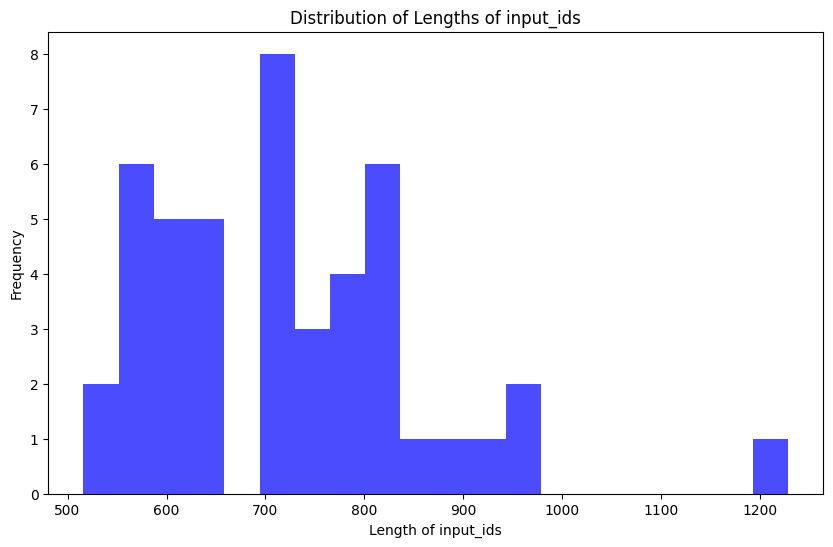

In [15]:
import matplotlib.pyplot as plt


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset['train']]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [16]:
import numpy as np

lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]

print(f"Mean: {np.mean(lengths)}")

# Calculate the 95th percentile
print(f"95th percentile: {np.percentile(lengths, 95)}")

# Calculate the max length
print(f"Max length: {np.max(lengths)}")

Mean: 723.725
95th percentile: 947.15
Max length: 1228


In [17]:
max_length = 1228  # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [18]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt2)

45


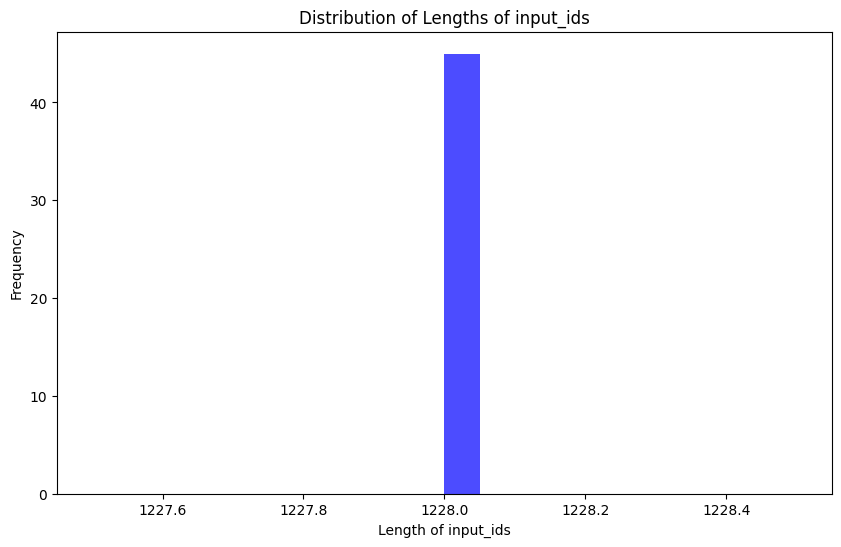

In [19]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [19]:
eval_prompt = (f"""
In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>. Your task is to generate the missing monologue between the <MONO> and </MONO> tags inside the provided text.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game called <TITLE>Elden Ring</TITLE>:

<CONTEXT>In <TITLE>Elden Ring</TITLE>, the introductory monologue delivered by a narrator sets the stage for the game's epic dark fantasy narrative. The player takes on the role of a Tarnished, one of the dead who yet live, called back to the Lands Between to restore the fractured world. The once-great Elden Ring has been shattered, and Queen Marika the Eternal has disappeared. On the Night of the Black Knives, the demigod Godwin the Golden was the first to fall, leading Marika's demigod offspring to seize the shards of the Elden Ring. Their newfound power triggered the Shattering, a catastrophic war that left the Lands Between in chaos and abandoned by the Greater Will. The Tarnished, including chieftains, sorcerers, and other notable figures, are beckoned by the call of long-lost grace to reclaim their destiny. As a Tarnished of no renown, the player must cross the fog to the Lands Between, face formidable foes, and seek to reunite the Elden Ring, ultimately striving to become the Elden Lord. The game explores themes of power, legacy, and redemption in a richly detailed and mysterious world.</CONTEXT>
    
<TITLE>Elden Ring</TITLE>'s introductory monologue is as follows:

<MONO> </MONO>

<END>

Answer:
""")

In [23]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=2000, repetition_penalty=1.15)[0],
                                skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>. Your task is to generate the missing dialogue line between the <MONO> and </MONO> tags inside the provided text.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the

In [20]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [21]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [22]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [23]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj,"
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    use_rslora=True,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 130023424 || all params: 3882094592 || trainable%: 3.3493110721192854


In [24]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

In [25]:
if torch.cuda.device_count() > 1:  # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [26]:
model = accelerator.prepare_model(model)

In [29]:
import transformers

project = "Monologue-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset["train"],
    eval_dataset=tokenized_val_dataset["train"],
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=360,
        learning_rate=3.5e-7,  # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=10,  # When to start reporting loss
        logging_dir="./logs",  # Directory for storing logs
        save_strategy="steps",  # Save the model checkpoint every logging step
        save_steps=10,  # Save checkpoints every 50 steps
        evaluation_strategy="steps",  # Evaluate the model every logging step
        eval_steps=10,  # Evaluate and save checkpoints every 50 steps
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two va

Step,Training Loss,Validation Loss
10,1.665500,1.674745


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


Step,Training Loss,Validation Loss
10,1.665500,1.674745
20,1.568700,1.606281
30,1.538300,1.548669
40,1.442100,1.494075
50,1.357800,1.442526
60,1.387800,1.391700
70,1.333500,1.338345
80,1.147900,1.280149
90,1.048600,1.227278
100,1.227500,1.183610


C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\utils\other.py:581: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-666db8ca-3f95cd1a2a43f2e866365981;91b573ca-4b93-4d30-8f2e-a1940566ed4d)

Cannot access gated repo for url https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2/resolve/main/config.json.
Access to model mistralai/Mistral-7B-Instruct-v0.2 is restricted. You must be authenticated to access it. - silently ignoring the lookup for the file config.json in mistralai/Mistral-7B-Instruct-v0.2.
  warnings.warn(
C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\utils\save_and_load.py:154: UserWarning: Could not find a config file in mistralai/Mistral-7B-Instruct-v0.2 - will assume that the vocabulary was not modified.
  warnings.warn(
C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.c

KeyboardInterrupt: 

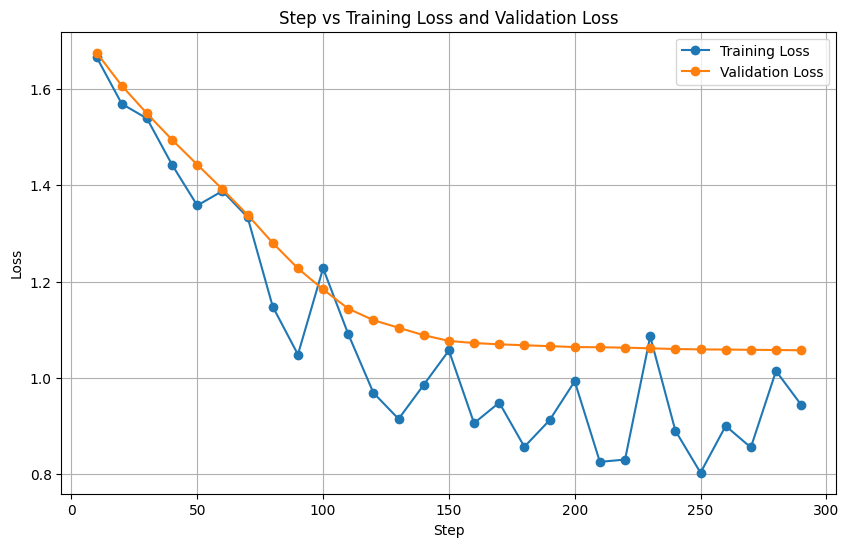

In [32]:
import pandas as pd
# Updating the DataFrame with the new column names
# Load the data
data = {
    "Step": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200,
             210, 220, 230, 240, 250, 260, 270, 280, 290],
    "Training Loss": [1.66550, 1.56870, 1.53830, 1.44210, 1.35780, 1.38780, 1.33350, 1.14790, 1.04860,
                      1.22750, 1.09100, 0.96920, 0.91500, 0.98570, 1.05700, 0.90620, 0.94880, 0.85720,
                      0.91230, 0.99310, 0.82590, 0.83070, 1.08610, 0.89070, 0.80340, 0.90050, 0.85580,
                      1.01450, 0.94430],
    "Validation Loss": [1.67475, 1.60628, 1.54866, 1.49407, 1.44252, 1.39170, 1.33834, 1.28014, 1.22728,
                        1.18361, 1.14382, 1.11993, 1.10419, 1.08873, 1.07682, 1.07244, 1.06976, 1.06784,
                        1.06597, 1.06413, 1.06372, 1.06286, 1.06148, 1.06010, 1.05922, 1.05893, 1.05840,
                        1.05799, 1.05745]
}
df = pd.DataFrame(data)

# Plotting the data with updated labels
plt.figure(figsize=(10, 6))
plt.plot(df["Step"], df["Training Loss"], marker='o', label="Training Loss")
plt.plot(df["Step"], df["Validation Loss"], marker='o', label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Step vs Training Loss and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-Monologue-finetune2/checkpoint-290")

In [10]:
eval_prompt = (f"""
In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>. Your task is to generate the missing dialogue line between the <MONO> and </MONO> tags inside the provided text. Your task is to generate the missing monologue between the <MONO> and </MONO> tags inside the provided text.


<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game called <TITLE>Elden Ring</TITLE>:

<CONTEXT>In <TITLE>Elden Ring</TITLE>, the introductory monologue delivered by a narrator sets the stage for the game's epic dark fantasy narrative. The player takes on the role of a Tarnished, one of the dead who yet live, called back to the Lands Between to restore the fractured world. The once-great Elden Ring has been shattered, and Queen Marika the Eternal has disappeared. On the Night of the Black Knives, the demigod Godwin the Golden was the first to fall, leading Marika's demigod offspring to seize the shards of the Elden Ring. Their newfound power triggered the Shattering, a catastrophic war that left the Lands Between in chaos and abandoned by the Greater Will. The Tarnished, including chieftains, sorcerers, and other notable figures, are beckoned by the call of long-lost grace to reclaim their destiny. As a Tarnished of no renown, the player must cross the fog to the Lands Between, face formidable foes, and seek to reunite the Elden Ring, ultimately striving to become the Elden Lord. The game explores themes of power, legacy, and redemption in a richly detailed and mysterious world.</CONTEXT>
    
<TITLE>Elden Ring</TITLE>'s introductory monologue is as follows:

<MONO> </MONO>

<END>
"""
)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1500, repetition_penalty=1.25)[0],
                                skip_special_tokens=True))
    #save the results to a list
    answer = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1500, repetition_penalty=1.25)[0],
                                skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>. Your task is to generate the missing dialogue line between the <MONO> and </MONO> tags inside the provided text. our task is to generate the missing dialogue line between the <MONO> and </MONO> tags inside the provided text.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's se

In [232]:
def evaluation_func(example):
    
    return f"""
In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>.Your task is to generate the missing monologue between the <MONO> and </MONO> tags inside the provided text.

The monologue should be only one and generated after the word Answer, it should also be relatively large and feel like a natural introduction to the game world described in the context, while it should not start by addressing the player directly and it should not contain the name of the game.

Do not use the line "Welcome traveler" or its abbreviations as the first line of the monologue.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game called <TITLE>{example['Game']}</TITLE>:

<CONTEXT>{example['Context']}</CONTEXT>
    
<TITLE>{example['Game']}</TITLE>'s introductory monologue is as follows:

<MONO> </MONO>

<END>

Answer:
"""

   

In [233]:
import pandas as pd
 # Create an evaluation data frame for each example in the test dataset
eval_df = pd.DataFrame(test_dataset['train'])
eval_df['description'] = eval_df.apply(evaluation_func, axis=1)

In [234]:
# create a new dataframe from the Dialogue column of the eval_df
test_monologues = eval_df['Monologue']

In [235]:
eval_df = eval_df[['description']]

In [236]:
eval_df

,description
0,"\nIn the following text, there is a descriptio..."
1,"\nIn the following text, there is a descriptio..."
2,"\nIn the following text, there is a descriptio..."
3,"\nIn the following text, there is a descriptio..."
4,"\nIn the following text, there is a descriptio..."


In [237]:
#for each element in the eval_df, generate an answer from the model
answers = []

In [238]:
#make the model generate answers for all the dialogues in the eval_df
for i in range(0, len(eval_df)):
    model_input = eval_tokenizer(eval_df['description'][i], return_tensors="pt").to("cuda")
    ft_model.eval()
    with torch.no_grad():
        answer = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=2000, repetition_penalty=1.25)[0],
                                skip_special_tokens=True)
        answers.append(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [239]:
len(answers)

5

In [240]:
#make the answers into a dataframe
answers_df = pd.DataFrame(answers, columns=['Monologue'])
#export the answers to an excel file
answers_df.to_excel('Mistral_Monologues_Full.xlsx', index=False)

In [241]:
#import the answers from the excel file answes_test.xlsx with a column named Dialogue
answers_df = pd.read_excel('Mistral_Monologues_Full.xlsx')
#name the column Dialogue
answers_df.columns = ['Monologue']
answers_df

,Monologue
0,"\nIn the following text, there is a descriptio..."
1,"\nIn the following text, there is a descriptio..."
2,"\nIn the following text, there is a descriptio..."
3,"\nIn the following text, there is a descriptio..."
4,"\nIn the following text, there is a descriptio..."


In [242]:
#for each line in the answers_df, keep only the text after the Answer: tag
answers_df['Monologue'] = answers_df['Monologue'].str.split('Answer:').str[1]

In [243]:
answers_df

,Monologue
0,"\nAs we stand at the precipice of another era,..."
1,"\n\n<MONO>From ancient times, man has sought s..."
2,"\n\n<MONO>You have been chosen, brave adventur..."
3,"\nAs the sun dips below the horizon, casting l..."
4,"\n\n<MONO>You wake up in darkness, your head p..."


In [244]:
#export the answers to an excel file
answers_df.to_excel('Mistral_Monologue_Answers_Only.xlsx', index=False)

In [249]:
import pandas as pd
#import the answers from the excel file answes_test.xlsx with a column named Dialogue
answers_df = pd.read_excel('Mistral_Monologue_Answers_Only.xlsx')
#name the column Dialogue
answers_df.columns = ['Monologue']

In [250]:
#convert everything in the answers_df to a string
answers_df = answers_df.map(str)

In [251]:
answers_df

,Monologue
0,\n<MONO>As we stand at the precipice of anothe...
1,"\n<MONO>Welcome, traveler, to this land of ete..."
2,"\n\n<MONO>Welcome traveler, to the harsh and u..."
3,\n\n<MONO>Five years have passed since the eve...
4,"\n<MONO>Welcome to the Wasteland, traveler. Th..."


In [260]:
#itterate through the answers_df and if the <LINE> </LINE> tags are present, keep the text between the tags for all the pairs if there are two pairs keep the second pair
import re

for i in range(0, len(answers_df)):
    matches = re.findall(r'<MONO>(.*?)</MONO>', answers_df['Monologue'][i])
    if len(matches) > 0:
        answers_df.loc[i, 'Monologue'] = matches[0]

#remove the /n from the answers_df
answers_df = answers_df.replace('\n', '', regex=True)
        
answers_df

,Monologue
0,"As we stand at the precipice of another era, t..."
1,"Welcome, traveler, to this land of eternal tor..."
2,"Welcome traveler, to the harsh and untamed fro..."
3,Five years have passed since the events surrou...
4,"Welcome to the Wasteland, traveler. This land ..."


In [262]:
# remove the from the test dialogues
test_monologues

0    War has changed. It's no longer about nations,...
1    In the Age of Ancients the world was unformed,...
2    So you want to hear a story, huh? What about t...
3    Eora: a world where mortals live, die, and are...
4    War. War never changes. The Romans waged war t...
Name: Monologue, dtype: object

# BERT Score

In [264]:
# Calculate BERTScore
from bert_score import score
import numpy as np

# Lists of candidates and references
candidates = answers_df['Monologue'].tolist()
references = test_monologues.tolist()
# Ensure that each candidate has a corresponding reference
assert len(candidates) == len(references), "Each candidate must have a corresponding reference."

# Calculate BERTScore for each pair
precision_scores = []
recall_scores = []
f1_scores = []

for cand, ref in zip(candidates, references):
    P, R, F1 = score([cand], [ref], lang='en')
    precision_scores.append(P.numpy())
    recall_scores.append(R.numpy())
    f1_scores.append(F1.numpy())
    

# Calculate the average of each metric
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Precision: 0.8349611
Average Recall: 0.8226248
Average F1 Score: 0.82871735


In [265]:
import warnings
from rouge import Rouge
import pandas as pd

# Suppress warnings if necessary
warnings.filterwarnings('ignore')

# Assuming the DataFrame and columns are properly set
# Ensure these columns contain strings
candidates = answers_df['Monologue'].tolist()  # Replace 'candidate_column' with your DataFrame column
references = test_monologues.tolist()  # Replace 'reference_column' with your DataFrame column

# Ensure that each candidate has a corresponding reference
assert len(candidates) == len(references), "Each candidate must have a corresponding reference."

# Initialize the Rouge object
rouge = Rouge()

# Initialize dictionaries to hold aggregated scores
rouge_1_scores = {'f': [], 'p': [], 'r': []}
rouge_2_scores = {'f': [], 'p': [], 'r': []}
rouge_l_scores = {'f': [], 'p': [], 'r': []}

# Calculate ROUGE scores for each pair
for cand, ref in zip(candidates, references):
    scores = rouge.get_scores(cand, ref, avg=False)[0]  # Obtain scores for the first (and only) pair
    # Store ROUGE scores in respective dictionaries
    rouge_1_scores['f'].append(scores['rouge-1']['f'])
    rouge_1_scores['p'].append(scores['rouge-1']['p'])
    rouge_1_scores['r'].append(scores['rouge-1']['r'])
    
    rouge_2_scores['f'].append(scores['rouge-2']['f'])
    rouge_2_scores['p'].append(scores['rouge-2']['p'])
    rouge_2_scores['r'].append(scores['rouge-2']['r'])
    
    rouge_l_scores['f'].append(scores['rouge-l']['f'])
    rouge_l_scores['p'].append(scores['rouge-l']['p'])
    rouge_l_scores['r'].append(scores['rouge-l']['r'])

# Calculate the average of each ROUGE metric
def average_score(score_list):
    return sum(score_list) / len(score_list) if score_list else 0

print("Average ROUGE-1 Scores:", {k: average_score(v) for k, v in rouge_1_scores.items()})
print("Average ROUGE-2 Scores:", {k: average_score(v) for k, v in rouge_2_scores.items()})
print("Average ROUGE-L Scores:", {k: average_score(v) for k, v in rouge_l_scores.items()})


Average ROUGE-1 Scores: {'f': 0.17951848006315418, 'p': 0.2074501428649394, 'r': 0.16261329157964144}
Average ROUGE-2 Scores: {'f': 0.018690965430843722, 'p': 0.02561437142393997, 'r': 0.015241315095087582}
Average ROUGE-L Scores: {'f': 0.16040394604610636, 'p': 0.1846046270820883, 'r': 0.14562152995380667}


In [270]:
# Generate 3 random numbers from 1 to 5 without duplicates
import random

random.seed(42)
random_numbers = random.sample(range(1, 5), 3)
random_numbers

[1, 4, 2]